In [1]:
import torch

torch.manual_seed(42)

from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig, LlamaModel
import torch
from torch import compile
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_from_disk
import transformers
from tqdm import tqdm
import pandas as pd
import yaml
import contextlib
import os
import time
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload 2

from transformers import PreTrainedTokenizerFast, AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v0.1")
tokenizer = AutoTokenizer.from_pretrained("/work/frink/models/llama3-8B-HF")
tokenizer.pad_token = tokenizer.eos_token

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

city_dataset = load_from_disk("./data/ravel/city_one_token")
city_train_set = city_dataset["train"]
city_test_set = city_dataset["test"]

from src.data_utils import get_ravel_collate_fn

ravel_collate_fn = get_ravel_collate_fn(tokenizer, disentangling=False)

batch_size = 32  # 50 or so
data_loader = DataLoader(
    city_train_set, batch_size=batch_size, collate_fn=ravel_collate_fn, shuffle=False
)  # batch_size, collate_fn=collate_fn)
test_data_loader = DataLoader(
    city_test_set, batch_size=batch_size, collate_fn=ravel_collate_fn, shuffle=False
)

for batch in data_loader:
    break

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [2]:
# @torch.compile #Apparently this fails when used inside jupyter notebooks but is fine if i make dedicated scripts
from src.llama3.model import RavelInterpretorHypernetwork
from src.utils import InterpretorModelOutput
import wandb

hypernetwork = RavelInterpretorHypernetwork(
    model_name_or_path="/work/frink/models/llama3-8B-HF",
    num_editing_heads=16,
    intervention_layer=6
)
hypernetwork = hypernetwork.to("cuda")
hypernetwork.load_model("/work/frink/sun.jiu/hypernetwork-editor/ravel_city_layer_6_one_token/final_model.pt")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [6]:
hypernetwork.eval_accuracy(test_data_loader, inference_mode="column_argmax")

(0.3436123348017621,
 2.734281077980995,
 [1,
  11,
  14,
  15,
  19,
  21,
  22,
  26,
  28,
  31,
  32,
  35,
  37,
  39,
  44,
  45,
  47,
  48,
  49,
  52,
  55,
  59,
  61,
  62,
  63,
  71,
  72,
  73,
  74,
  77,
  78,
  81,
  83,
  89,
  94,
  95,
  96,
  98,
  106,
  108,
  109,
  110,
  114,
  115,
  119,
  120,
  126,
  132,
  137,
  138,
  141,
  147,
  148,
  150,
  152,
  159,
  160,
  161,
  167,
  171,
  174,
  178,
  182,
  191,
  192,
  196,
  198,
  199,
  203,
  205,
  206,
  207,
  208,
  210,
  211,
  213,
  218,
  219])

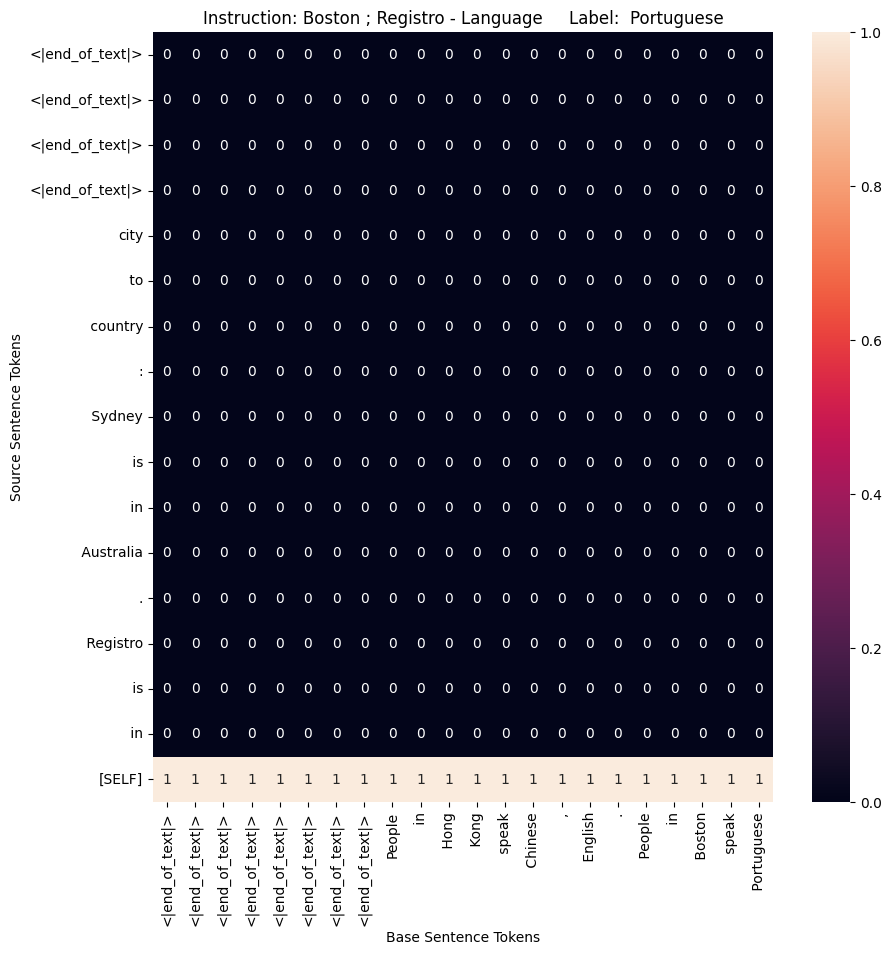

In [11]:
hypernetwork.plot_heatmap(test_data_loader, idxs=100, inference_mode="column_argmax")

 North America  North America


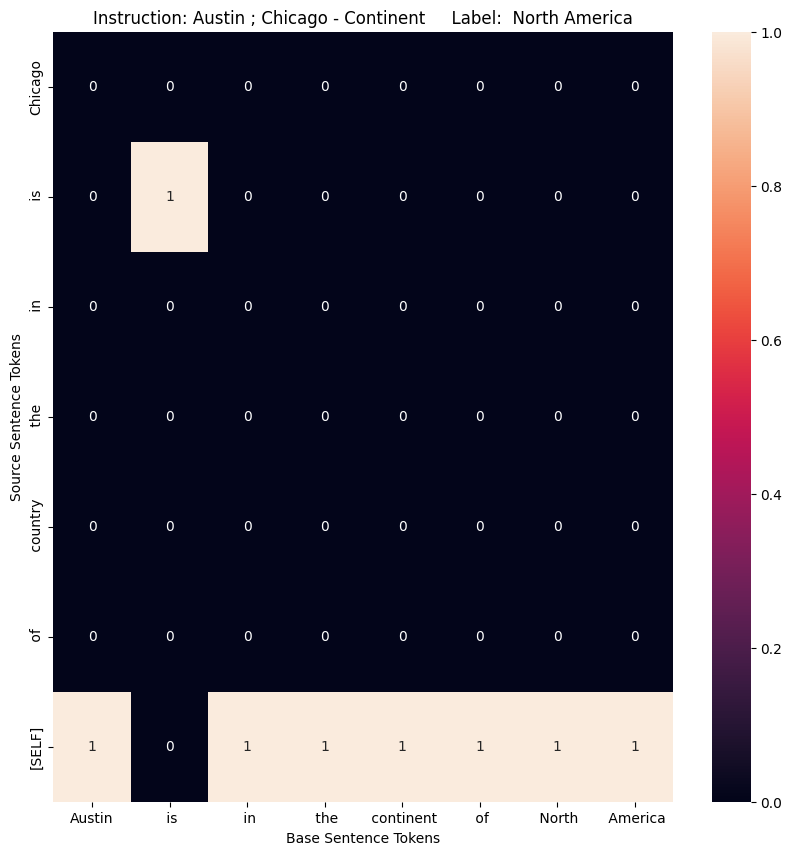

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

batch_id = 0
example_id = 0

batch_size = 10  # 50 or so
data_loader = DataLoader(
    city_train_set, batch_size=batch_size, collate_fn=ravel_collate_fn, shuffle=False
)  # batch_size, collate_fn=collate_fn)
test_data_loader = DataLoader(
    city_test_set, batch_size=batch_size, collate_fn=ravel_collate_fn, shuffle=False
)

for i, batch in enumerate(data_loader):
    if i == batch_id:
        break
    
results = hypernetwork.inspect_batch_prediction_ouptuts(batch, argmax_intervention=True)

editor_input_ids = batch["editor_input_ids"][example_id]
base_input_ids = batch["base_input_ids"][example_id]
source_input_ids = batch["source_input_ids"][example_id]
intervention_weight = results["batch_intervention_weight"][example_id]
label = batch["labels"][example_id]

assert intervention_weight.size() == (len(source_input_ids) + 1, len(base_input_ids))

source_axis = [tokenizer.decode([i]) for i in source_input_ids] + ["[SELF]"]
base_axis = [tokenizer.decode([i]) for i in base_input_ids]
editor_text = tokenizer.decode(editor_input_ids)

label_idx = label != -100
label = label[label_idx]
label = tokenizer.decode(label)
pred_output = results["batch_output"][example_id]

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(intervention_weight.float().cpu().numpy(), xticklabels=base_axis, yticklabels=source_axis, ax=ax, annot=True)

ax.set_title(f"Instruction: {editor_text}     Label: {label}")
ax.set_xlabel("Base Sentence Tokens")
ax.set_ylabel("Source Sentence Tokens")
print(pred_output, label)

In [46]:
base_input_ids.size()[0], source_input_ids.size()[0]

(8, 6)

In [76]:
intervention_weight = torch.zeros(1, source_input_ids.size()[0] + 1, base_input_ids.size()[0]) 
intervention_weight[:, -1, :] = 1.0

# intervention_weight[0, -1, 2] = 0.0
# intervention_weight[0, 5, 2] = 1.0

intervention_weight[0, -1, 3] = 0.0
intervention_weight[0, 1, 3] = 1.0

In [77]:
editor_input_ids = batch["editor_input_ids"][example_id]
base_input_ids = batch["base_input_ids"][example_id]
base_attention_mask = batch["base_attention_mask"][example_id]
source_input_ids = batch["source_input_ids"][example_id]
source_attention_mask = batch["source_attention_mask"][example_id]
labels = batch["labels"][example_id]

In [78]:
pred = hypernetwork.forward(
    editor_input_ids = editor_input_ids.unsqueeze(0).to("cuda"),
    base_input_ids = base_input_ids.unsqueeze(0).to("cuda"),
    base_attention_mask = base_attention_mask.unsqueeze(0).to("cuda"),
    source_input_ids = source_input_ids.unsqueeze(0).to("cuda"),
    source_attention_mask = source_attention_mask.unsqueeze(0).to("cuda"),
    labels = labels.unsqueeze(0).to("cuda"),
    intervention_weight=intervention_weight.to("cuda")
)

 English  English


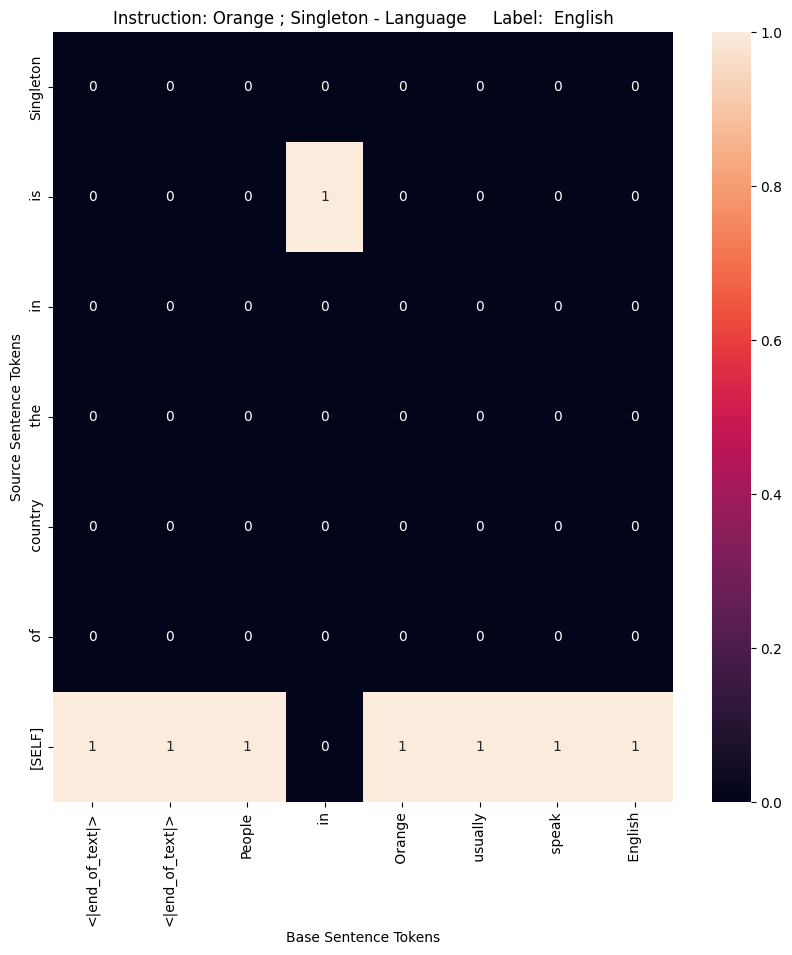

In [79]:
intervention_weight = intervention_weight.squeeze()
assert intervention_weight.size() == (len(source_input_ids) + 1, len(base_input_ids))

source_axis = [tokenizer.decode([i]) for i in source_input_ids] + ["[SELF]"]
base_axis = [tokenizer.decode([i]) for i in base_input_ids]
editor_text = tokenizer.decode(editor_input_ids)

batch_pred_ids = torch.argmax(pred["logits"], dim=-1)
pred_ids = batch_pred_ids[0]

label_idx = labels != -100
output_idx = torch.zeros_like(label_idx)
output_idx[:-1] = label_idx[1:]

labels = labels[label_idx]
pred_ids = pred_ids[output_idx]

pred_output = tokenizer.decode(pred_ids)
label = tokenizer.decode(labels)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(intervention_weight.float().cpu().numpy(), xticklabels=base_axis, yticklabels=source_axis, ax=ax, annot=True)

ax.set_title(f"Instruction: {editor_text}     Label: {label}")
ax.set_xlabel("Base Sentence Tokens")
ax.set_ylabel("Source Sentence Tokens")
print(pred_output, label)

In [65]:
pred_ids, labels

(tensor([311], device='cuda:0'), tensor([6498]))